# M-BERT: Experiments across modality, time, language, and country

**Multilingual Experiment Outline:**  
**Training data:** data from Manifest project (version 2018-2)   
**Testing data:** data from Manifesto project random test split     
**Evaluaiton:** overall performance, per country, per languagne and over time  
**Model:** https://huggingface.co/distilbert-base-multilingual-cased




## Loading the packages, functions and dataset

In [ ]:
import os
os.chdir("..")
from utils.BERT_utils import *
os.chdir("en")

In [2]:
path_file = "../data/multilingual_data_2018-2.csv"
path_results = "../results/04_mbert"
path_model = "../results/04_mbert/"
model_checkpoint = "distilbert-base-multilingual-cased"
model_append = "-manifesto-2018"

# Data Preparation: 

In [ ]:
# set seeds for reproducibility
transformers.set_seed(3)
transformers.enable_full_determinism(3)
np.random.seed(3)

In [ ]:
# load data
data = pd.read_csv(path_file,  index_col=None)

# ensure variables as string
data['topic_8'] = data['topic_8'].astype(str) # categories
data['text'] = data['text'].astype(str) # topic

In [ ]:
# overview languages
print(data['language'].unique())

['swedish' 'norwegian' 'danish' 'finnish' 'icelandic' 'dutch' 'french'
 'german' 'italian' 'spanish' 'catalan' 'galician' 'greek' 'portuguese'
 'english' 'japanese' 'hebrew' 'turkish' 'armenian' 'bosnian'
 'bosnian-cyrillic' 'bulgarian' 'croatian' 'czech' 'estonian' 'georgian'
 'hungarian' 'latvian' 'lithuanian' 'macedonian' 'romanian' 'montenegrin'
 'polish' 'russian' 'serbian-cyrillic' 'serbian-latin' 'slovak'
 'slovenian']


In [ ]:
for i in data['language'].unique(): 
  print(i + ": " + data.loc[data['language'] == i, ].iloc[0, 1])

swedish: Miljöpartiet de Gröna går till val på en politik för fler jobb,
norwegian: Miljøpartiet De Grønnes mål er et medmenneskelig samfunn
danish: Ny Alliance ønsker at gøre op med den blokpolitik, der præger Danmark.
finnish: Vihreä politiikka on rohkeaa.
icelandic: Allir landsmenn eiga að hafa jafnan rétt óháð kynferði, stétt, stöðu, aldri, búsetu, uppruna og efnahag.
dutch: Iedereen spreekt tegenwoordig over milieu en de opwarming van de aarde.
french: DÉI GRÉNG présentent dans les pages qui viennent leurs priorités en cinq chapitres pour les élections du 13 juin 2004.
german: Wir wollen in einer modernen Gesellschaft und einer starken Demokratie leben, in der Menschen gleichberechtigt sind und faire Chancen haben.
italian: La lotta per l’eliminazione della mafia e della corruzione non è solo un obiettivo e un impegno per la legalità e la civiltà del paese, ma la precondizione per il suo rilancio economico.
spanish: La necesidad de una plataforma de movilización social claramente 

## Train-Test-Validation data sets

In [ ]:
# X: text, Y: topic
X = data['text'] 
Y = data['topic_8']

# Y numeric
Y_numeric = pd.factorize(Y)[0]
classes = pd.factorize(Y)[1]

# mapping: numeric -> category
dic_y_mapping = {n:label for n,label in enumerate(classes)}

# reverese mapping: catgory -> numeric
dic_y_mapping_inverse = dict(map(reversed, dic_y_mapping.items()))
dic_y_mapping_inverse

# test-train-validation split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_numeric, train_size=.8, random_state=77)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, train_size=0.5, random_state=77)

# overview splits
print('X', X.shape)
print('X_train', X_train.shape, round(X_train.shape[0]/X.shape[0], 2))
print('X_test', X_test.shape, round(X_test.shape[0]/X.shape[0], 2))
print('X_val', X_val.shape, round(X_val.shape[0]/X.shape[0], 2))

X (996008,)
X_train (796806,) 0.8
X_test (99601,) 0.1
X_val (99601,) 0.1


In [ ]:
# create same split for country & language variable for evaluation per country
country = data['countryname']
X_train, X_test, country_train , country_test  = train_test_split(X, country, train_size=.8, random_state=77)
X_test, X_val, country_test, country_val = train_test_split(X_test, country_test, train_size=0.5, random_state=77)


language = data['language']
X_train, X_test, language_train , language_test  = train_test_split(X, language, train_size=.8, random_state=77)
X_test, X_val, language_test, language_val = train_test_split(X_test, language_test, train_size=0.5, random_state=77)

In [ ]:
# create dataset for training
dataset = {'train':Dataset.from_dict({'label':Y_train,'text':X_train}),
     'validation':Dataset.from_dict({'label':Y_val,'text':X_val}),
     'test':Dataset.from_dict({'label':Y_test,'text':X_test})
     }
dataset = DatasetDict(dataset)

# structure data set
print(dataset)

# example
dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 796806
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 99601
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 99601
    })
})


{'label': 0,
 'text': 'Kalkınma işbirliğine yönelik mali, beşeri ve kurumsal kapasite ile hukuki altyapımızı güçlendirerek, bu imkânların toplumsal refahımızın yükseltilmesine yönelik kullanılmasını sağlayacağız.'}

## Preprocessing the data

In [ ]:
# Chose model and corresponing tokenize
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
batch_size = 16

In [ ]:
# Encode data set
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)
# Note truncation=True: input truncated to the maximum length accepted by the model

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset

Map:   0%|          | 0/796806 [00:00<?, ? examples/s]

Map:   0%|          | 0/99601 [00:00<?, ? examples/s]

Map:   0%|          | 0/99601 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 796806
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 99601
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 99601
    })
})

In [ ]:
def preprocess_tesst_example(examples):
  return tokenizer(examples, truncation=True)


for i in data['language'].unique(): 
  print(preprocess_tesst_example(data.loc[data['language'] == i, ].iloc[0, 1]))

{'input_ids': [101, 75311, 37735, 45834, 10104, 144, 10129, 15248, 10113, 16634, 10712, 25460, 10217, 10110, 19470, 10847, 13296, 51759, 117, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [101, 75311, 61629, 45834, 10190, 144, 10129, 80664, 10107, 23237, 10163, 10131, 10172, 63247, 66983, 12554, 21083, 108283, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [101, 11459, 21892, 278, 18140, 10129, 10160, 89468, 10303, 10172, 10140, 61657, 55556, 117, 10118, 20157, 76408, 10165, 17271, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [101, 31826, 32206, 11013, 91929, 95299, 20878, 10135, 25470, 10237, 37663, 10113, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [101, 11101, 10835, 31361, 63247, 10805, 10483, 12071, 34320, 10201, 29265, 10206, 186, 13837, 10123, 273, 29782, 12332, 87147, 101

## Fine-tuning the model

Fine-tuning with huggingface trainer: https://huggingface.co/transformers/v3.0.2/main_classes/trainer.html

In [ ]:
metric = load_metric('f1')
metric_name = "f1"
num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
model_name = model_checkpoint.split("/")[-1]

<ipython-input-19-47b4617a7a88>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('f1')


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.bias', 'classifie

In [ ]:
args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    seed=0,
    #push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,1.015500,0.979126,0.559504


Epoch,Training Loss,Validation Loss,F1
1,1.015500,0.979126,0.559504
2,0.853100,0.942954,0.585149
3,0.733100,0.973206,0.591601


TrainOutput(global_step=149403, training_loss=0.8991072472999831, metrics={'train_runtime': 29573.4502, 'train_samples_per_second': 80.83, 'train_steps_per_second': 5.052, 'total_flos': 5.185222983641126e+16, 'train_loss': 0.8991072472999831, 'epoch': 3.0})

In [ ]:
# save the fine tuned model & tokenizer
model.save_pretrained(path_model + model_checkpoint + model_append)
tokenizer.save_pretrained(path_model + model_checkpoint + model_append)

('./drive/MyDrive/Paper BERT/results/04_MBERT/2023-04-10/model/tokenizer_config.json',
 './drive/MyDrive/Paper BERT/results/04_MBERT/2023-04-10/model/special_tokens_map.json',
 './drive/MyDrive/Paper BERT/results/04_MBERT/2023-04-10/model/vocab.txt',
 './drive/MyDrive/Paper BERT/results/04_MBERT/2023-04-10/model/added_tokens.json',
 './drive/MyDrive/Paper BERT/results/04_MBERT/2023-04-10/model/tokenizer.json')

In [ ]:
# load model 
model = AutoModelForSequenceClassification.from_pretrained(path_model + model_checkpoint + model_append, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(path_model + model_checkpoint + model_append, local_files_only=True)

# Experiment 1:
Evaluation on training, test and valdiation set

In [ ]:
# save results in...
path_results = directory_results + '/Exp1-2'

### Evaluation on training

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["train"])

In [ ]:
Y_pred_training, Y_train_classes = predict_BERT(encoded_dataset["train"], dic_y_mapping, Y_train)
evaluation_training = evaluation_table(Y_train_classes,  Y_pred_training, domain= 'within-domain', data_description ="training")
evaluation_training 

### Evaluation on validation data

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["validation"])

{'eval_loss': 0.9732059836387634,
 'eval_f1': 0.591601181735135,
 'eval_runtime': 307.0583,
 'eval_samples_per_second': 324.372,
 'eval_steps_per_second': 20.276,
 'epoch': 3.0}

In [ ]:
Y_pred_validation, Y_val_classes = predict_BERT(encoded_dataset["validation"], dic_y_mapping, Y_val)
evaluation_validation = evaluation_table(Y_val_classes,  Y_pred_validation, domain= 'within-domain', data_description ="validation")
evaluation_validation 

### Evaluation on test set

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["test"])

{'eval_loss': 0.9719064235687256,
 'eval_f1': 0.5940792323051509,
 'eval_runtime': 312.9922,
 'eval_samples_per_second': 318.222,
 'eval_steps_per_second': 19.892,
 'epoch': 3.0}

In [ ]:
# get predictions and evaluation metrices
Y_pred_testing, Y_test_classes = predict_BERT(encoded_dataset["test"], dic_y_mapping, Y_test)
evaluation_testing = evaluation_table(Y_test_classes, Y_pred_testing, domain= 'within-domain', data_description ="testing")
evaluation_testing 

,metric,score,domain,data
0,Accuracy,0.674792,within-domain,testing
1,F1 score (macro),0.594079,within-domain,testing


Accuracy: 0.67
Detail:


,precision,recall,f1-score,support,data
economy,0.693409,0.744878,0.718222,24843.0,testing
external relations,0.735677,0.706769,0.720933,7431.0,testing
fabric of society,0.621209,0.609207,0.615149,11231.0,testing
freedom and democracy,0.616475,0.578650,0.596964,6014.0,testing
no topic,0.414226,0.139437,0.208641,710.0,testing
political system,0.601151,0.564611,0.582308,11105.0,testing
social groups,0.624192,0.537235,0.577458,9346.0,testing
welfare and quality of life,0.715094,0.751737,0.732958,28921.0,testing


<Figure size 640x480 with 0 Axes>

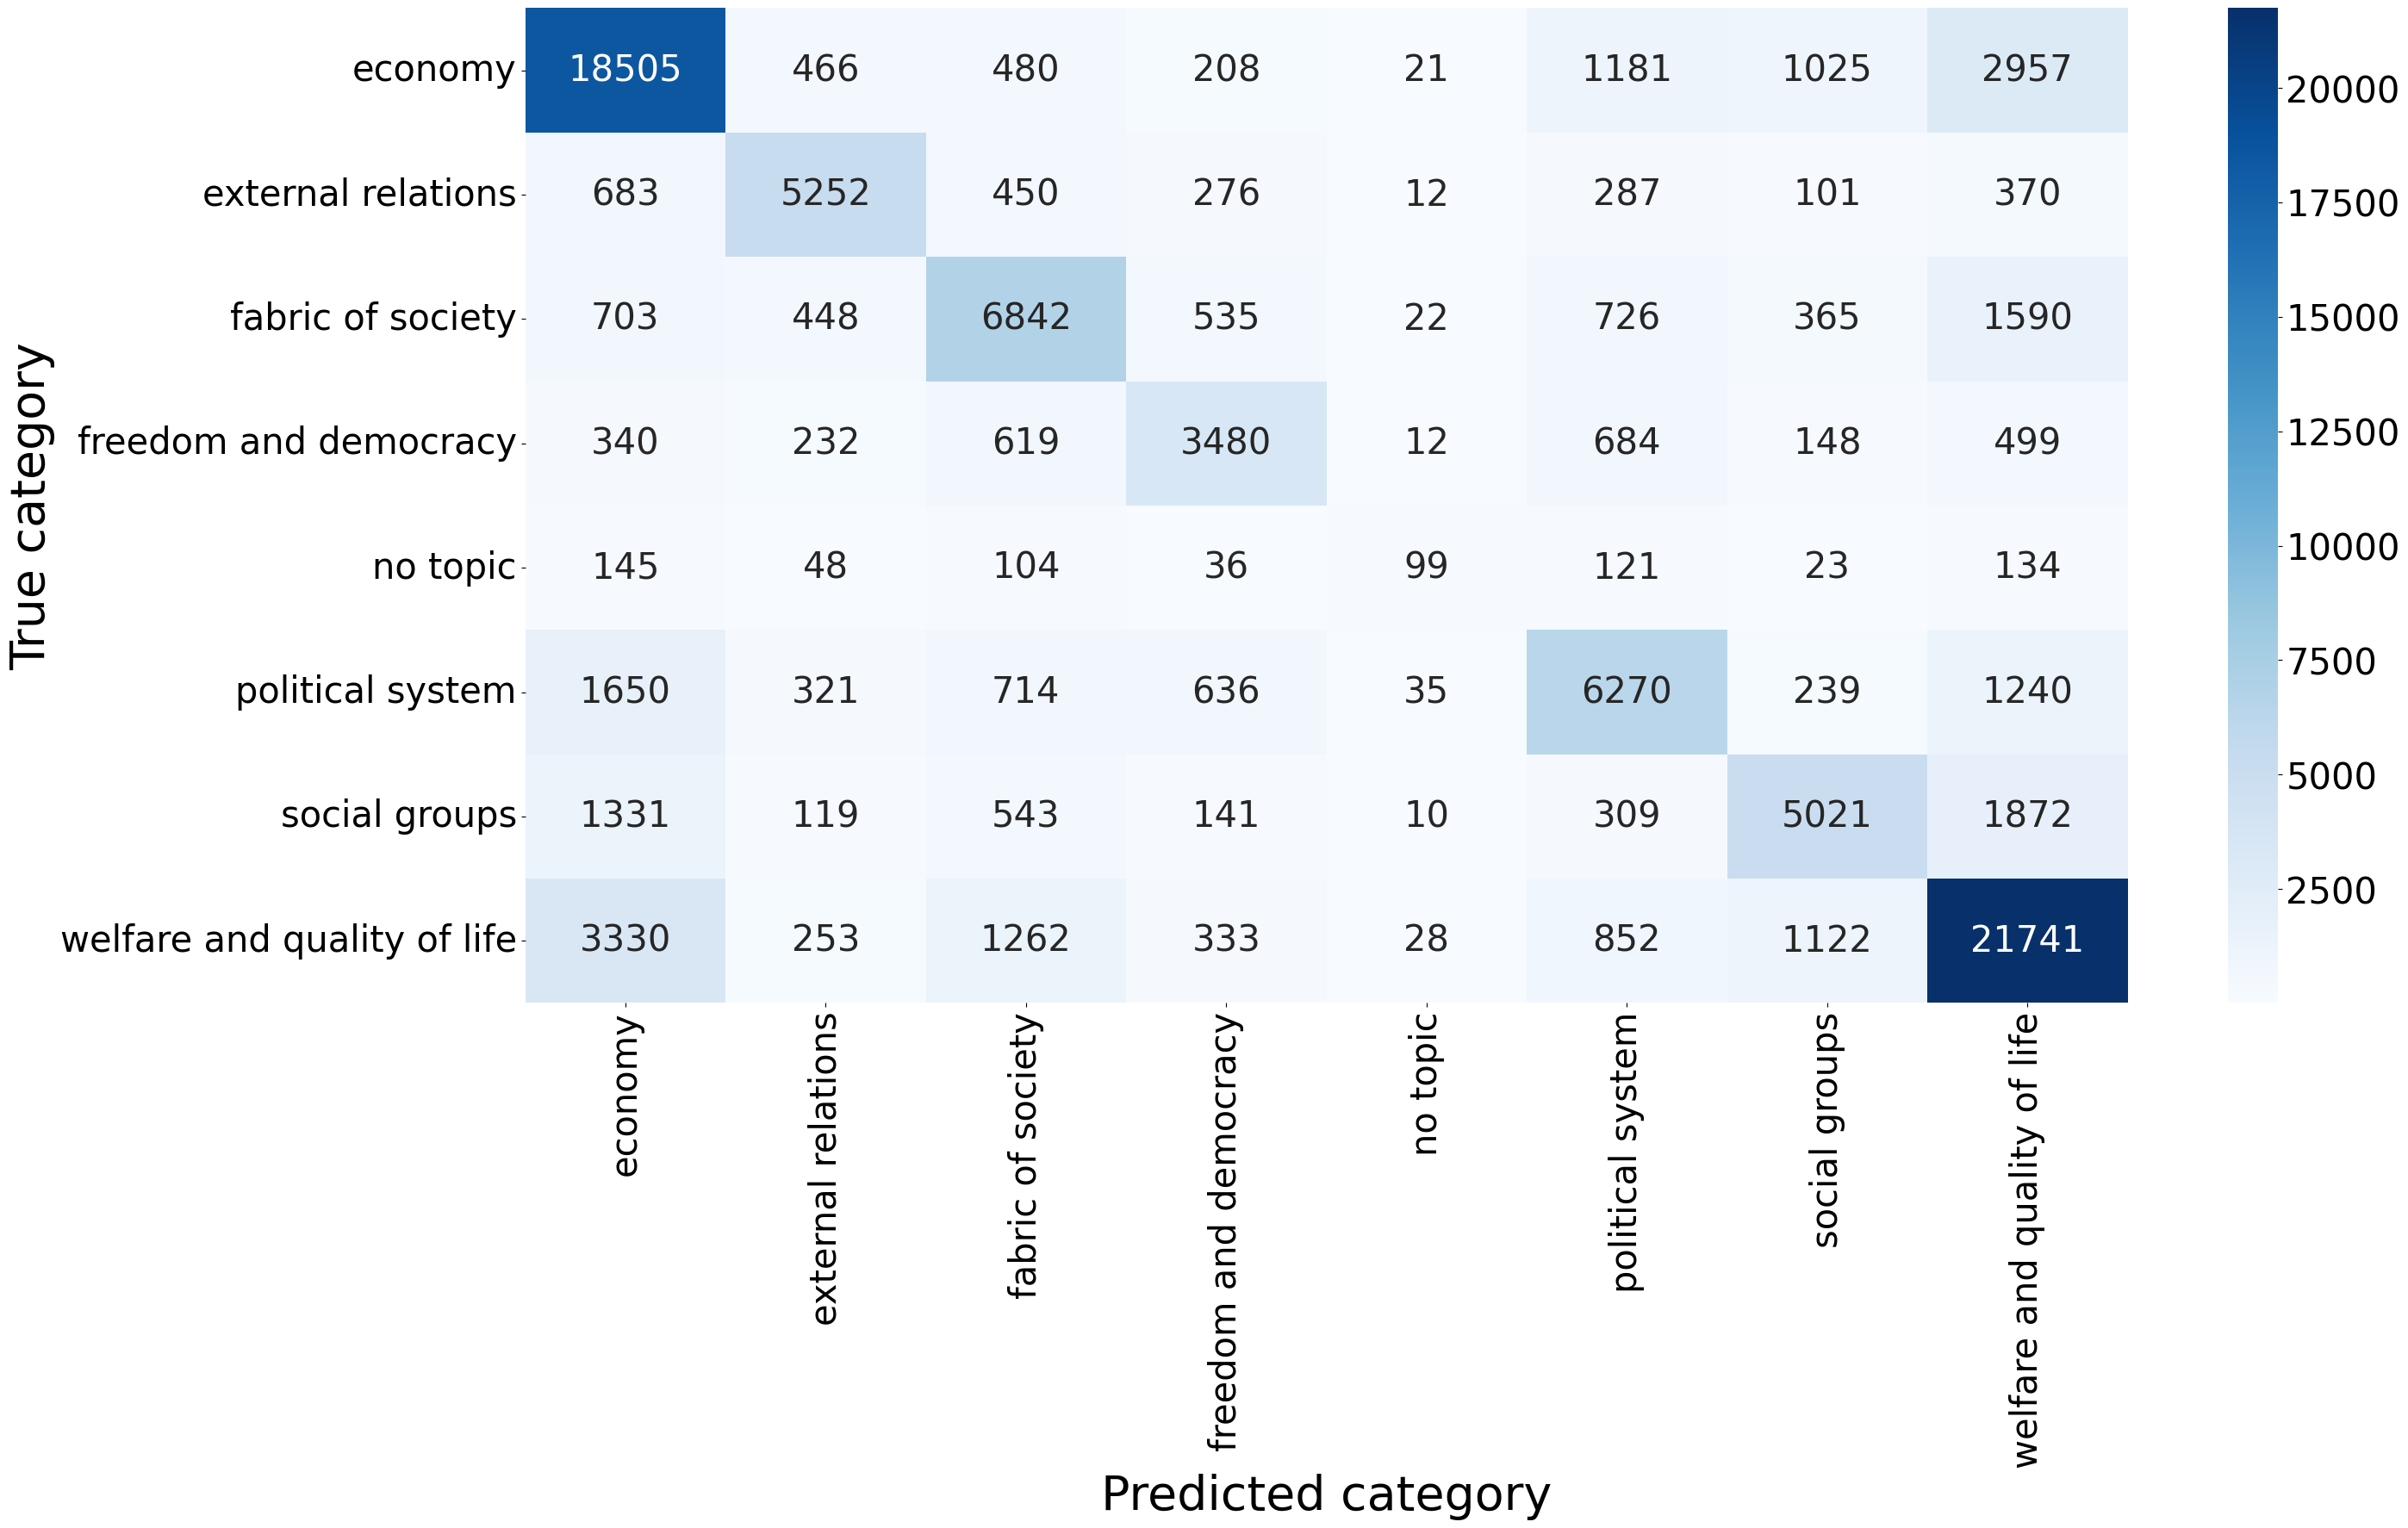

In [ ]:
classification_report_testing = evaluation_per_category(Y_test_classes, Y_pred_testing, data_description ="testing", path_results = path_results, figsize=(30,15))
classification_report_testing

# Experiment 2:
**Training data:** data from Manifest project (version 2018-2) with English speaking countries from paper   
**Testing data:** data from Manifest project (version 2022-1)   
**Model:** DistilBERT   
**Result:** Works well 

In [ ]:
# load data
path_file =  './drive/MyDrive/Paper BERT/data/multilingual_data_2022-1.csv'
data_2022 = pd.read_csv(path_file,  index_col=None)

# ensure variables as string
data_2022['topic_8'] = data_2022['topic_8'].astype(str) # categories
data_2022['text'] = data_2022['text'].astype(str) # topic

data_2022.head(3)

,countryname,text,language,code,document_index,date,topic_8
0,Sweden,Miljöpartiet de Gröna går till val på en polit...,swedish,408.0,81,200609,economy
1,Sweden,"fler företag,",swedish,402.0,81,200609,economy
2,Sweden,"levande landsbygd,",swedish,301.0,81,200609,political system


In [ ]:
# no data for 2018
data_2022[data_2022["date"]==201800]

,countryname,text,language,code,document_index,date,topic_8


In [ ]:
data_future = data_2022[data_2022["date"]>201800]
print(data_future.shape)

X_future = data_future['text'] 
Y_future = data_future['topic_8']

(251949, 7)


In [ ]:
# creat numeric Y
Y_future_numeric = [dic_y_mapping_inverse[y_test] for y_test in Y_future]
Y_future_numeric = np.array(Y_future_numeric, dtype= 'object')
Y_future_numeric

array([4, 2, 2, ..., 2, 0, 4], dtype=object)

In [ ]:
# create data set
dataset = {'future':Dataset.from_dict({'label':Y_future_numeric,'text':X_future})}
dataset_future = DatasetDict(dataset)
encoded_dataset_future = dataset_future.map(preprocess_function, batched=True)

Map:   0%|          | 0/251949 [00:00<?, ? examples/s]

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset_future["future"])

{'eval_loss': 1.1157277822494507,
 'eval_f1': 0.5278377622742579,
 'eval_runtime': 683.1536,
 'eval_samples_per_second': 368.803,
 'eval_steps_per_second': 23.05,
 'epoch': 3.0}

In [ ]:
Y_pred_future, Y_future_classes = predict_BERT(encoded_dataset_future["future"], dic_y_mapping, Y_future_numeric)

evaluation_future = evaluation_table(Y_future,Y_pred_future, domain= 'cross-domain', data_description ="future")
evaluation_future.to_csv(path_resutls + '/evaluation_future.csv')
evaluation_future

,metric,score,domain,data
0,Accuracy,0.631124,cross-domain,future
1,F1 score (macro),0.527838,cross-domain,future


Accuracy: 0.63
Detail:


<Figure size 640x480 with 0 Axes>

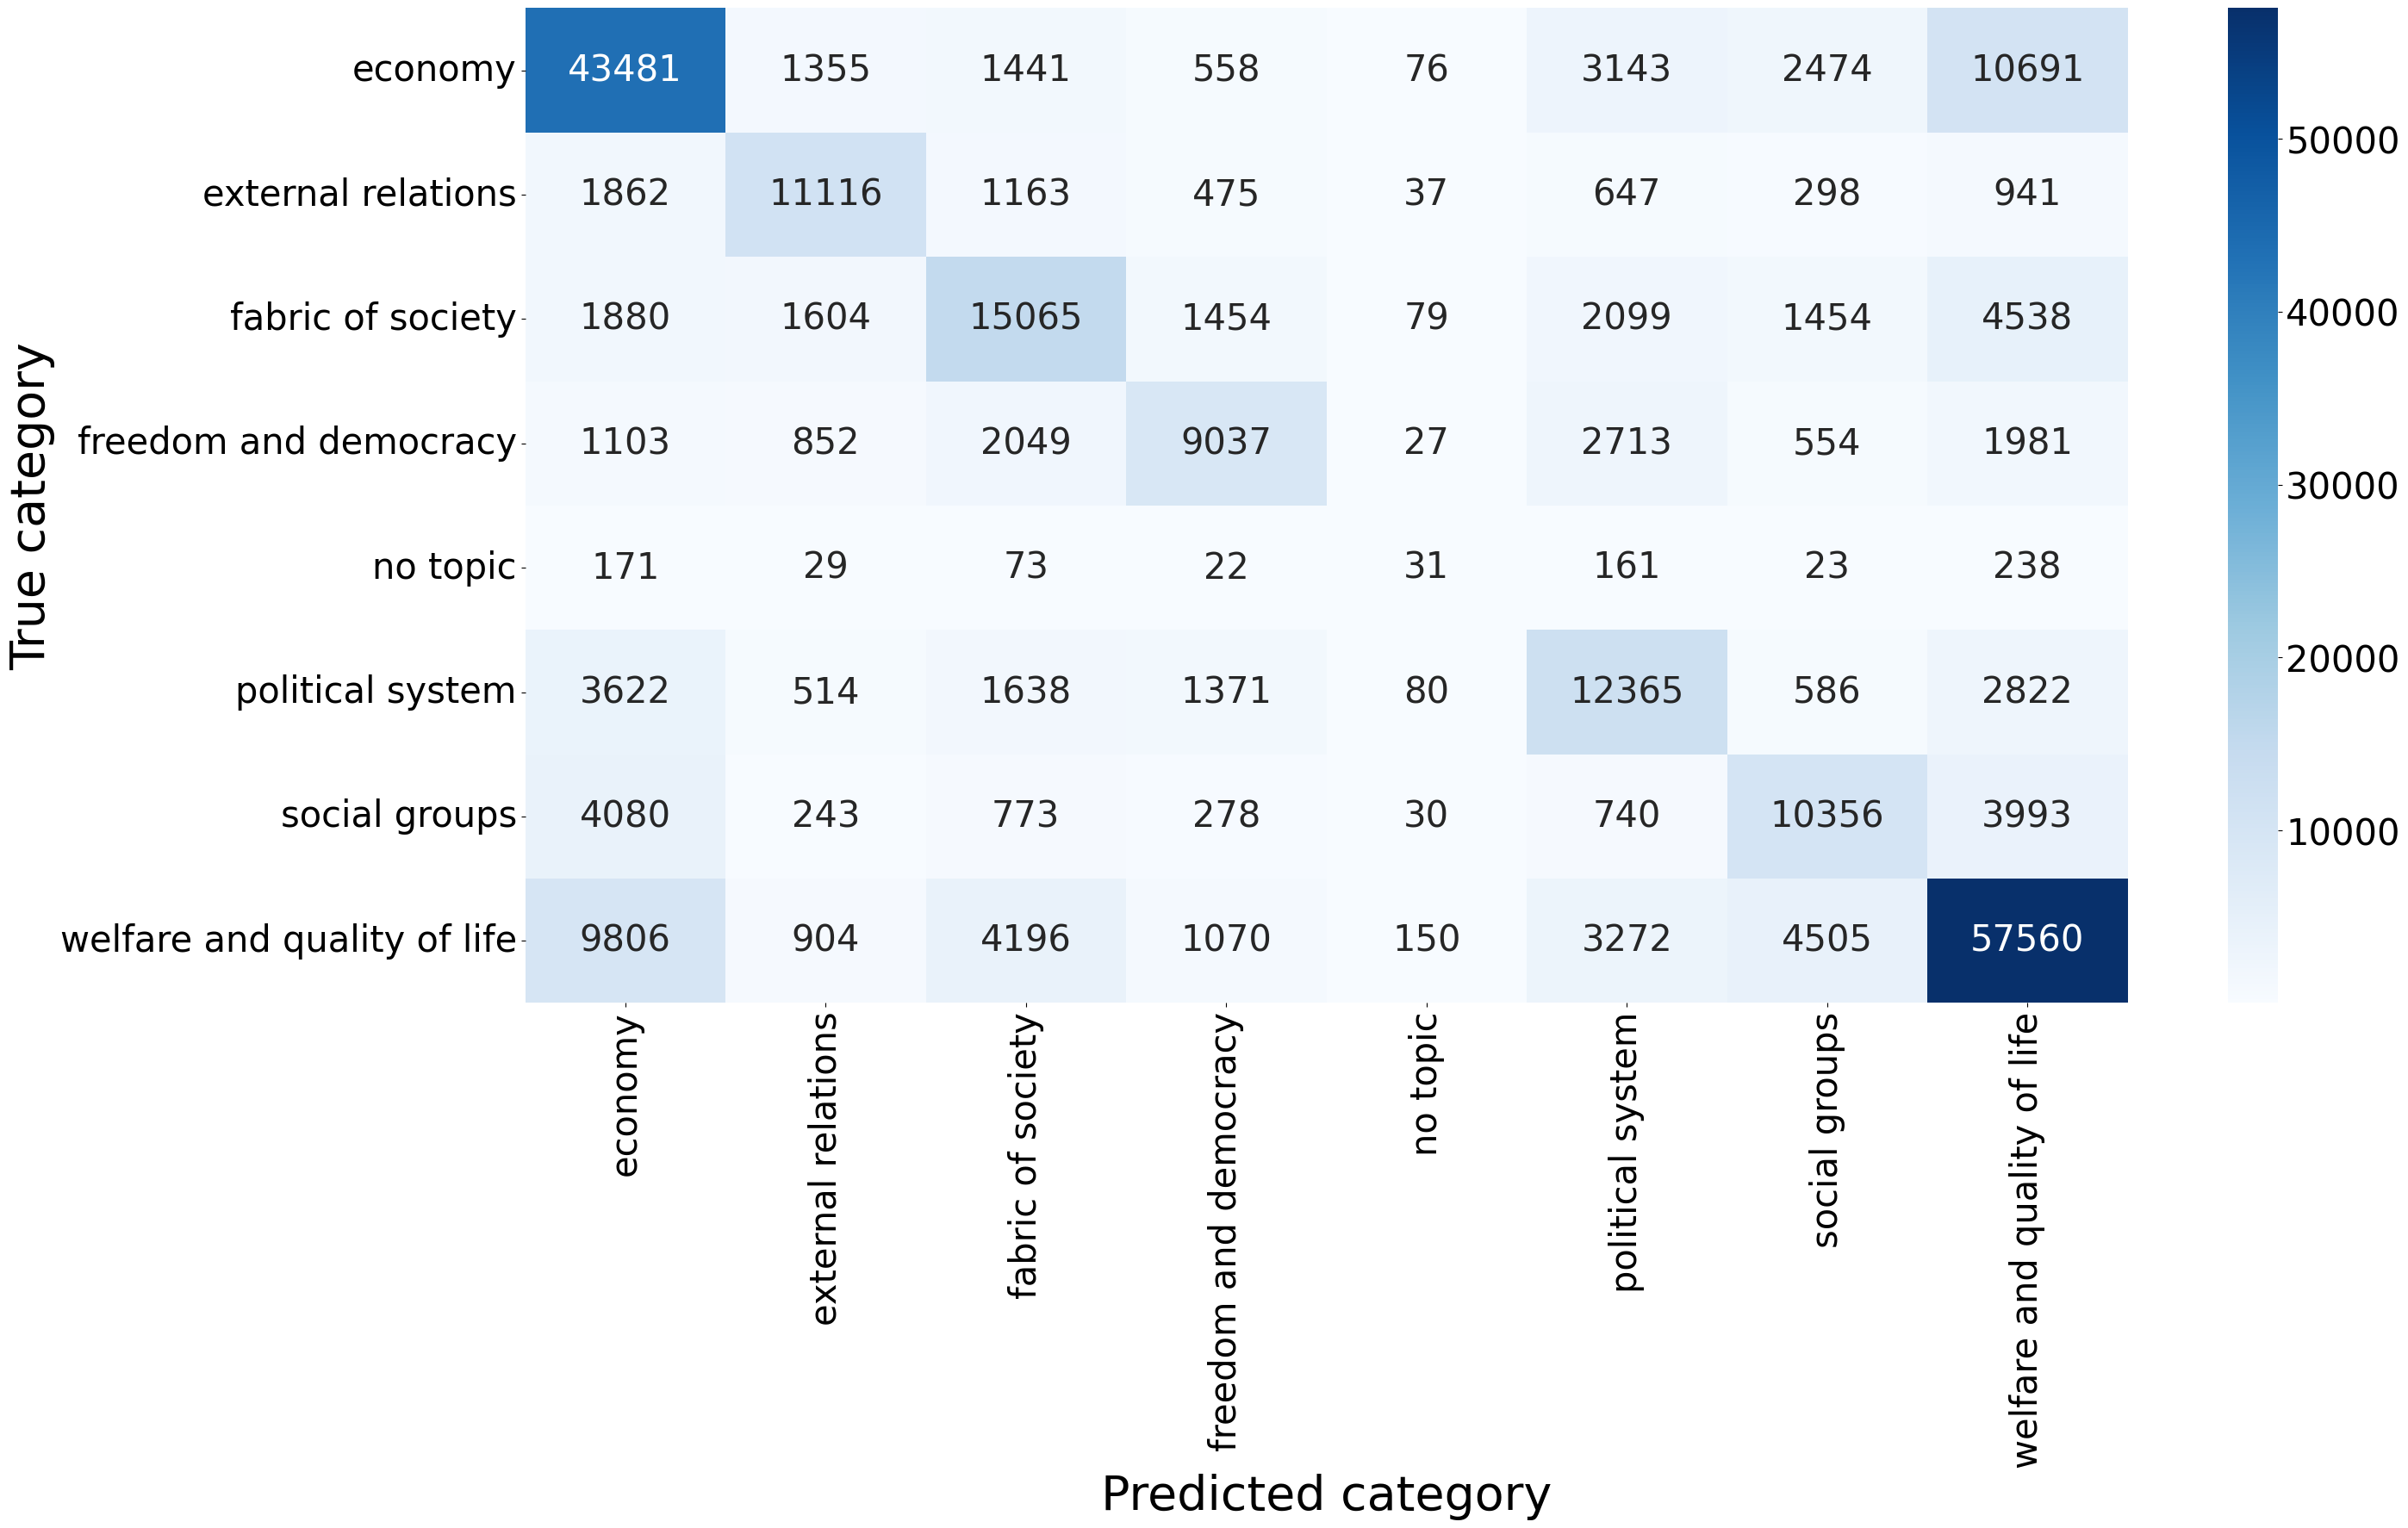

In [ ]:
classification_report_future = evaluation_per_category(Y_future, Y_pred_future, data_description ="future", path_results = path_results, figsize=(30,15))

### Overview results Exp 1-2

In [ ]:
eval_metrics = pd.concat([evaluation_training, evaluation_validation, evaluation_testing, evaluation_future])
eval_metrics.reset_index(drop = True, inplace = True)
eval_metrics.to_csv(path_results + '/eval_metrics.csv')
eval_metrics

,metric,score,domain,data
0,Accuracy,0.798833,within-domain,training
1,F1 score (macro),0.739307,within-domain,training
2,Accuracy,0.674792,within-domain,testing
3,F1 score (macro),0.594079,within-domain,testing
4,Accuracy,0.631124,cross-domain,future
5,F1 score (macro),0.527838,cross-domain,future


In [ ]:
classification_report = pd.concat([classification_report_testing, classification_report_future])
classification_report.to_csv(path_results + '/classification_report_' + '.csv', index=True)
classification_report

,precision,recall,f1-score,support,data
economy,0.693409,0.744878,0.718222,24843.0,testing
external relations,0.735677,0.706769,0.720933,7431.0,testing
fabric of society,0.621209,0.609207,0.615149,11231.0,testing
freedom and democracy,0.616475,0.578650,0.596964,6014.0,testing
no topic,0.414226,0.139437,0.208641,710.0,testing
political system,0.601151,0.564611,0.582308,11105.0,testing
social groups,0.624192,0.537235,0.577458,9346.0,testing
welfare and quality of life,0.715094,0.751737,0.732958,28921.0,testing
economy,0.658753,0.687784,0.672955,63219.0,future
external relations,0.668953,0.672108,0.670527,16539.0,future


# Expeirment 3: Evaluation per country


In [ ]:
# save results in...
path_results = directory_results + '/Exp3_country'
os.mkdir(path_results)

In [ ]:
country_eval = pd.DataFrame(index =  ["Accuracy", "F1 macro", "Obsevations", "Number of no topics", "Percentage no topics"])

for i in country.unique():
  country_eval[i] = evaluation_country(i, country_test, Y_test_classes, Y_pred_testing)

country_eval = country_eval.sort_values( by= 'Accuracy', axis=1, ascending=False)
country_eval.to_csv(path_results + '/country_eval.csv')

In [ ]:
# 5 best predicted countries
country_eval.iloc[:, 0:5]

In [ ]:
# 5 worst predicted countries
country_eval.sort_values( by= 'Accuracy', axis=1, ascending=True).iloc[:, 0:5]

In [ ]:
# highest percentage no topics
country_eval.sort_values( by= 'Percentage no topics', axis=1, ascending=False).iloc[:, 0:5]

In [ ]:
# most observations
country_eval.sort_values( by= 'Obsevations', axis=1, ascending=False).iloc[:, 0:5]

In [ ]:
# least observations
country_eval.sort_values( by= 'Obsevations', axis=1, ascending=True).iloc[:, 0:5]

In [ ]:
from scipy.stats import spearmanr 
print(spearmanr(country_eval.loc['Accuracy']  , country_eval.loc['Percentage no topics']))
print(spearmanr(country_eval.loc['Accuracy']  , country_eval.loc['Obsevations']))

In [ ]:
# Confusion metric for different countries
for i in country.unique():
  print(i)
  print(len(Y_test_classes[country_test == i]))
  classification_report_per_country_test_set = evaluation_per_category(Y_test_classes[country_test == i], np.array(Y_pred_testing)[country_test == i], data_description = i+'_random_test_split', path_results = path_results, figsize=(30,15))

# Expeirment 4: Evaluation per language


In [ ]:
# save results in...
path_results = directory_results + '/Exp4_language'

In [ ]:
laguage_eval = pd.DataFrame(index =  ["Accuracy", "F1 macro", "Obsevations", "Number of no topics", "Percentage no topics"])

for i in language.unique():
  laguage_eval[i] = evaluation_language(i, language_test, Y_test_classes, Y_pred_testing)

laguage_eval = laguage_eval.sort_values( by= 'Accuracy', axis=1, ascending=False)
laguage_eval.to_csv(path_results + '/laguage_eval.csv')

In [ ]:
# 5 best predicted languages
laguage_eval.iloc[:, 0:5]

In [ ]:
# 5 worst predicted languages
laguage_eval.sort_values( by= 'Accuracy', axis=1, ascending=True).iloc[:, 0:5]

In [ ]:
# highest percentage no topics
laguage_eval.sort_values( by= 'Percentage no topics', axis=1, ascending=False).iloc[:, 0:5]

In [ ]:
# most observations
laguage_eval.sort_values( by= 'Obsevations', axis=1, ascending=False).iloc[:, 0:5]

In [ ]:
# least observations
laguage_eval.sort_values( by= 'Obsevations', axis=1, ascending=True).iloc[:, 0:5]

In [ ]:
from scipy.stats import spearmanr 
print(spearmanr(laguage_eval.loc['Accuracy']  , laguage_eval.loc['Percentage no topics']))
print(spearmanr(laguage_eval.loc['Accuracy']  , laguage_eval.loc['Obsevations']))

In [ ]:
# Confusion metric for different languages
for i in language.unique():
  print(i)
  print(len(Y_test_classes[language_test == i]))
  classification_report_per_language_test_set = evaluation_per_category(Y_test_classes[language_test == i], np.array(Y_pred_testing)[language_test == i], data_description = i+'_random_test_split', path_results = path_results, figsize=(30,15))

# Packages

In [ ]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

In [ ]:
!pip list -v